In [32]:
! pip install keras-tuner --upgrade

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   -------------------------------------- - 122.9/129.1 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator 

In [18]:
# print(tf.config.list_physical_devices())
! nvidia-smi

Tue Apr 30 13:31:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.09                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8               10W /  N/A|   1846MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
print(tf.config.list_physical_devices())

# Check if TensorFlow is using GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Check if TensorFlow is using GPU for operations
print("Is TensorFlow using GPU:", tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1
Is TensorFlow using GPU: True


In [3]:
train_data_gen=ImageDataGenerator(rescale=1./255)
validation_data_gen=ImageDataGenerator(rescale=1./255)

In [4]:
train_generator=train_data_gen.flow_from_directory("data/train",
                                                   target_size=(48,48),
                                                   color_mode="grayscale",
                                                   batch_size=64,
                                                   class_mode="categorical")

validation_generator=validation_data_gen.flow_from_directory("data/test",
                                                   target_size=(48,48),
                                                   color_mode="grayscale",
                                                   batch_size=64,
                                                   class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [28]:
emotion_model=Sequential()

emotion_model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(48,48,1)))
emotion_model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
emotion_model.add(MaxPooling2D(pool_size=(2,2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
emotion_model.add(MaxPooling2D(pool_size=(2,2)))      
emotion_model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
emotion_model.add(MaxPooling2D(pool_size=(2,2))) 
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
emotion_model.add(Dropout(0.5))

emotion_model.add(Dense(7,activation="softmax"))

emotion_model.compile(optimizer=Adam(learning_rate=0.001,decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
model_history=emotion_model.fit_generator(train_generator,
                                          steps_per_epoch=28709//64,
                                          epochs=50,
                                          validation_data=validation_generator,
                                          validation_steps=7178//64)

C:\Users\Dell\AppData\Local\Temp\ipykernel_13908\2599096187.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=emotion_model.fit_generator(train_generator,


Epoch 1/50
448/448 [==============================] - 139s 307ms/step - loss: 1.8628 - accuracy: 0.2975 - val_loss: 1.5779 - val_accuracy: 0.4083
Epoch 2/50
448/448 [==============================] - 11s 25ms/step - loss: 1.5392 - accuracy: 0.4335 - val_loss: 1.4153 - val_accuracy: 0.4923
Epoch 3/50
448/448 [==============================] - 11s 25ms/step - loss: 1.4115 - accuracy: 0.4931 - val_loss: 1.3330 - val_accuracy: 0.5229
Epoch 4/50
448/448 [==============================] - 11s 25ms/step - loss: 1.3447 - accuracy: 0.5249 - val_loss: 1.2906 - val_accuracy: 0.5481
Epoch 5/50
448/448 [==============================] - 11s 26ms/step - loss: 1.3049 - accuracy: 0.5469 - val_loss: 1.2860 - val_accuracy: 0.5520
Epoch 6/50
448/448 [==============================] - 11s 26ms/step - loss: 1.2683 - accuracy: 0.5628 - val_loss: 1.2399 - val_accuracy: 0.5692
Epoch 7/50
448/448 [==============================] - 12s 26ms/step - loss: 1.2414 - accuracy: 0.5762 - val_loss: 1.2220 - val_accurac

In [30]:
def plot_loss_curves(history):
  plt.figure(figsize=(6,6))
  epochs=len(history.epoch)
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']


# Accuracy curve
  plt.title('Accuracy')
  plt.plot(range(epochs),accuracy,label='train_acc')
  plt.plot(range(epochs),val_accuracy,label='val_acc')
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()


# loss curve
  plt.figure()
  plt.title('Loss')
  plt.plot(range(epochs),loss,label='train_loss')
  plt.plot(range(epochs),val_loss,label='val_loss')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()

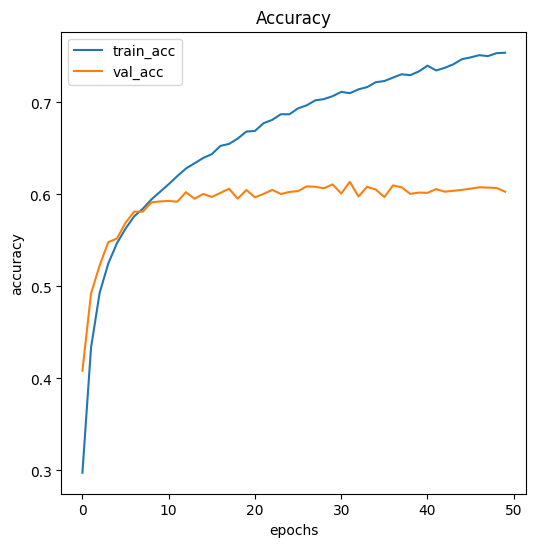

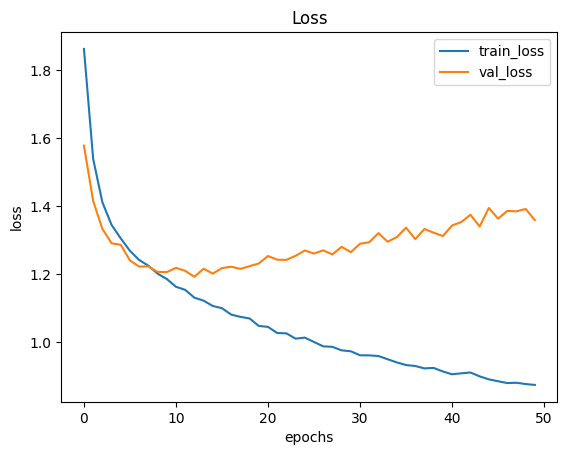

In [31]:
plot_loss_curves(model_history)

In [33]:
import keras_tuner
import keras

In [48]:
def build_model(hp):
    
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(
                                filters=hp.Int('conv_1_filter',min_value=32,max_value=64,step=16),
                                kernel_size=hp.Choice("conv_1_kernel_size",values=[3,5]),
                                activation='relu',
                                input_shape=(48,48,1)))
  
    model.add(keras.layers.Conv2D(
                                filters=hp.Int('conv_2_filter',min_value=64,max_value=128,step=16),
                                kernel_size=hp.Choice("conv_2_kernel_size",values=[3,5]),
                                activation='relu'))

    model.add(keras.layers.MaxPooling2D(
                                pool_size=hp.Choice("pool_size_1",values=[2,3])))

    model.add(keras.layers.Dropout(rate=hp.Choice("rate_1",[0.2,0.3,0.5])))

    

    model.add(keras.layers.Conv2D(
                                filters=hp.Int('conv_3_filter',min_value=128,max_value=512,step=16),
                                kernel_size=hp.Choice("conv_3_kernel_size",values=[3,5]),
                                activation='relu'))

    model.add(keras.layers.MaxPooling2D(
                                pool_size=hp.Choice("pool_size_2",values=[2,3])))

    model.add(keras.layers.Dropout(rate=hp.Choice("rate_2",[0.2,0.3,0.5])))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(units=hp.Int("units",min_value=128,max_value=1024),
                                activation="relu"))

    model.add(keras.layers.Dense(7,activation="softmax"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2,1e-3])),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
    return model

In [35]:
from kerastuner import RandomSearch
from kerastuner.engine import hyperparameters

In [49]:
tuner=RandomSearch(build_model,
                   objective="val_accuracy",
                   max_trials=5,
                   directory="output",
                   project_name="Image_classification")

In [50]:
tuner.search(train_generator,
             steps_per_epoch=28709//64,
             epochs=3,
             validation_data=validation_generator,
             validation_steps=7178//64)

Trial 5 Complete [00h 00m 44s]
val_accuracy: 0.2472098171710968

Best val_accuracy So Far: 0.5189732313156128
Total elapsed time: 00h 07m 53s


In [68]:
model=tuner.get_best_models(num_models=1)[0]
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 48, 48, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 48, 48, 1),
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'floa

In [69]:
model.fit(train_generator,
             steps_per_epoch=28709//64,
             epochs=50,
             validation_data=validation_generator,
             validation_steps=7178//64,
             initial_epoch=3)

Epoch 4/50
448/448 [==============================] - 138s 307ms/step - loss: 1.2397 - accuracy: 0.5278 - val_loss: 1.2147 - val_accuracy: 0.5280
Epoch 5/50
448/448 [==============================] - 19s 42ms/step - loss: 1.1680 - accuracy: 0.5566 - val_loss: 1.1905 - val_accuracy: 0.5400
Epoch 6/50
448/448 [==============================] - 19s 42ms/step - loss: 1.1049 - accuracy: 0.5820 - val_loss: 1.1415 - val_accuracy: 0.5640
Epoch 7/50
448/448 [==============================] - 19s 43ms/step - loss: 1.0448 - accuracy: 0.6056 - val_loss: 1.1251 - val_accuracy: 0.5699
Epoch 8/50
448/448 [==============================] - 19s 42ms/step - loss: 0.9898 - accuracy: 0.6269 - val_loss: 1.1135 - val_accuracy: 0.5806
Epoch 9/50
448/448 [==============================] - 19s 42ms/step - loss: 0.9254 - accuracy: 0.6539 - val_loss: 1.1225 - val_accuracy: 0.5730
Epoch 10/50
448/448 [==============================] - 19s 42ms/step - loss: 0.8632 - accuracy: 0.6773 - val_loss: 1.1212 - val_accura

In [70]:
model_json=emotion_model.to_json()
with open("emotion_model.json","w") as json_file:
    json_file.write(model_json)

emotion_model.save_weights("emotion_model.h5")